In [107]:
%load_ext autoreload
%autoreload 2
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Toy Example

We want to verify that the cdf loss helps in scenarios with limited data and label noise

In [269]:
class SimpleNoiseRegData(Dataset):
    def __init__(self, N, noise_scale = 0.2):
        super().__init__()
        if noise_scale < 0:
            # We use a data dependend noise!
            d_dim = 6
            self.weight = torch.Tensor([[-1,-0.1,0.1,0.4,1.3, 0]])
        else:
            d_dim = 5
            self.weight = torch.Tensor([[-1,-0.1,0.1,0.4,1.3]])
        
        # We first construct a very simple nonlinear regression problem, mapping from 5 dimensions to 1
        self.N = N
        self.data = torch.randn((N,d_dim))
        self.clean_labels = torch.einsum("ij, Bj -> Bi", self.weight, self.data)**2
        
        if noise_scale < 0:
            data_dependend_noise = torch.nn.functional.softplus(self.data[:,-1:]*5)
            self.labels = self.clean_labels + torch.normal(torch.zeros(self.clean_labels.shape), data_dependend_noise)
        else:
            self.labels = self.clean_labels + torch.normal(torch.zeros(self.clean_labels.shape), noise_scale)
        
    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        matching_idx = np.random.randint(self.N)
        return self.data[idx], self.labels[idx], self.data[matching_idx], self.labels[matching_idx] 
    

class SimpleModel(torch.nn.Module):
    def __init__(self, n_in, n_out, n_hidden):
        super().__init__()
        self.in_layer = torch.nn.Linear(n_in, n_hidden)
        self.out_layer = torch.nn.Linear(n_hidden, n_out)
        self.non_linearity = torch.nn.SELU()
    def forward(self, x):
        return self.out_layer(self.non_linearity(self.in_layer(x)))
    

class MatchingModel(torch.nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.in_layer = torch.nn.Linear(n_in, n_out,bias=False)
    def forward(self, x):
        #return self.in_layer(x) **2
        y = self.in_layer(x)
        return torch.stack((y[:,0] **2,y[:,1]),dim=1)
    
def relative_loss(x1, x2, label, rel_temperature=0.2):
    diff_1 = x1 - x2
    diff_2 = x2 - x1 
            
    log_prob_1_ge_2 = torch.special.log_ndtr(diff_1.flatten() / 2 ** 0.5 / rel_temperature)
    log_prob_2_ge_1 = torch.special.log_ndtr(diff_2.flatten() / 2 ** 0.5 / rel_temperature)
    combined =  torch.stack((log_prob_1_ge_2, log_prob_2_ge_1), dim=-1)
    return torch.nn.functional.nll_loss(combined, label, reduction="sum")
    
def mse_loss(x1, label):
    return torch.nn.functional.mse_loss(x1, label)

def nll_loss(output, label, var):
    return torch.sum(0.5 * (torch.log(2*torch.clamp(var,1e-6)**2) + (output - label)**2 / (2*torch.clamp(var,1e-6)**2)))

In [347]:
epochs = 1000
lr = 0.0001
n_samples = 5000
batch_size = 500
noise_scale = -1
model = SimpleModel(6,2,16)
#model = MatchingModel(6,2)
if torch.cuda.is_available():
        model = model.to("cuda")
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
dataset = SimpleNoiseRegData(n_samples, noise_scale=noise_scale)
train_loader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True) 

In [271]:
val_dataset = SimpleNoiseRegData(1000, noise_scale=noise_scale)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=False) 

In [359]:
#epochs = 1000
#lr = 0.001
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
with tqdm.tqdm(range(epochs), unit="epoch") as tepoch:
    for epoch in tepoch:
        total_loss = 0
        for (x, y, x2, y2) in train_loader:
            if torch.cuda.is_available():
                x = x.to("cuda")
                y = y.to("cuda")    
                x2 = x2.to("cuda")
                y2 = y2.to("cuda")  
            optimizer.zero_grad()
        
            out = model(x)
            out2 = model(x2)
        
            #uncertainty = (torch.nn.functional.softplus(out[:,1]) + torch.nn.functional.softplus(out2[:,1]))/2
            uncertainty = torch.nn.functional.softplus(out[:,1:])
            # get loss for the predicted output
            #loss = relative_loss(out[:,0], out2[:,0], (y2 > y)[:,0].long(), rel_temperature=uncertainty[:,0])
            #loss = relative_loss(out, out2, (y2 > y)[:,0].long()) + mse_loss(out, y)
            loss = relative_loss(out[:,0], out2[:,0], (y2 > y)[:,0].long(), rel_temperature=uncertainty[:,0]) + mse_loss(out[:,:1], y)
            #loss = mse_loss(out[:,:1], y)
            #loss = nll_loss(out[:,:1], y, uncertainty )
            # get gradients w.r.t to parameters
            loss.backward()
        
            # update parameters
            optimizer.step()
            total_loss += loss
        
        tepoch.set_postfix(loss=total_loss.item())
        #print('epoch {}, loss {}'.format(epoch, loss.item()))

100%|██████████| 1000/1000 [01:08<00:00, 14.49epoch/s, loss=2.46e+3]


PearsonRResult(statistic=0.9751927814599505, pvalue=0.0) 0.89480275


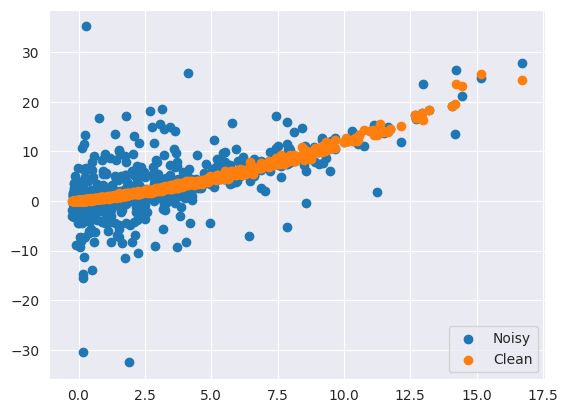

In [360]:
pred = model(val_dataset.data.to("cuda"))
plt.scatter(pred.cpu().detach().numpy()[:,0],val_dataset.labels[:,0], label="Noisy")
plt.scatter(pred.cpu().detach().numpy()[:,0],val_dataset.clean_labels[:,0], label="Clean")
print(stats.pearsonr(pred.cpu().detach().numpy()[:,0], val_dataset.clean_labels[:,0].cpu().detach().numpy()),np.mean((pred.cpu().detach().numpy()[:,0]- val_dataset.clean_labels[:,0].cpu().detach().numpy())**2))
plt.legend()
plt.show()

PearsonRResult(statistic=0.9737938727662905, pvalue=0.0) 1.4315695


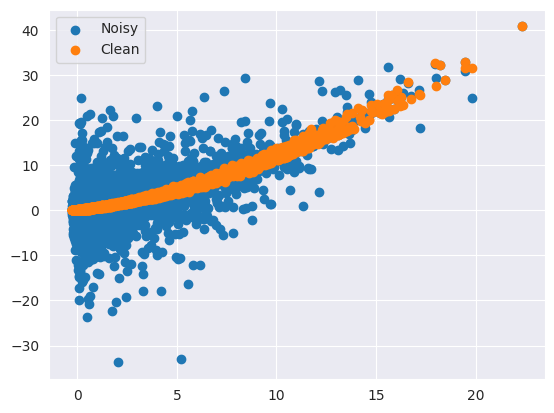

In [361]:
pred = model(dataset.data.to("cuda"))
plt.scatter(pred.cpu().detach().numpy()[:,0],dataset.labels[:,0], label="Noisy")
plt.scatter(pred.cpu().detach().numpy()[:,0],dataset.clean_labels[:,0], label="Clean")
print(stats.pearsonr(pred.cpu().detach().numpy()[:,0], dataset.clean_labels[:,0].cpu().detach().numpy()),np.mean((pred.cpu().detach().numpy()[:,0]- dataset.clean_labels[:,0].cpu().detach().numpy())**2))
plt.legend()
plt.show()

In [226]:
model_rel = model

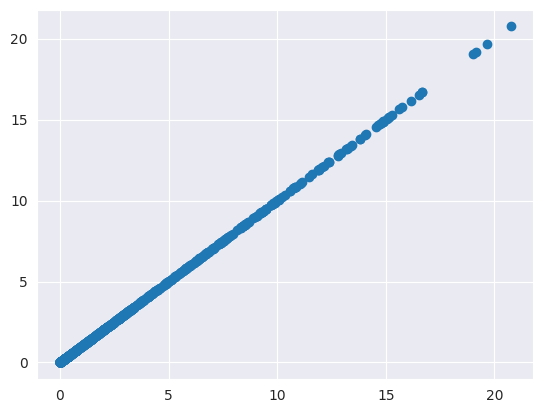

In [253]:
plt.scatter(val_dataset.clean_labels[:,0],val_dataset.clean_labels[:,0], label="Noisy")
#plt.scatter(predmse.cpu().detach().numpy()[:,0],dataset.clean_labels[:,0], label="Clean")

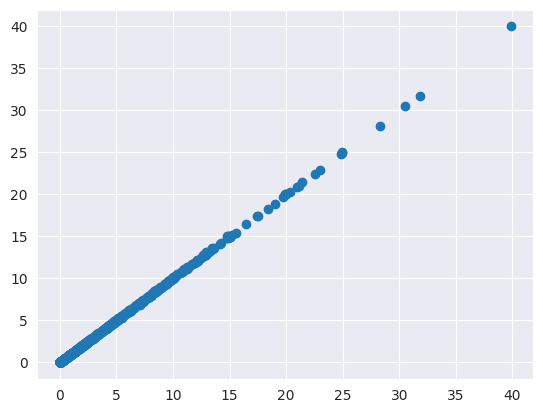

In [10]:
stats.pearsonr(predboth.cpu().detach().numpy()[:,0], dataset.labels[:,0])

PearsonRResult(statistic=0.9499538246314237, pvalue=0.0)

PearsonRResult(statistic=0.9989940112735061, pvalue=0.0)

In [27]:
stats.pearsonr(predrel2.cpu().detach().numpy()[:,0], dataset.labels[:,0])

PearsonRResult(statistic=0.9526229577305851, pvalue=0.0)

In [122]:
torch.nn.functional.softplus(pred[:,1])

tensor([6.9277e-01, 2.2500e+00, 5.1626e-01, 1.6364e+00, 1.4466e+00, 3.0530e+00,
        2.8679e+00, 1.1420e+00, 2.5090e+00, 1.9987e+00, 9.0958e-02, 2.4451e-01,
        3.0338e+00, 1.1070e+00, 9.9722e-01, 1.6601e+00, 5.0373e-01, 1.6115e-01,
        2.9511e+00, 3.4096e-01, 1.1832e-01, 1.2248e+00, 4.2783e-01, 3.8851e+00,
        1.7531e+00, 3.6001e-01, 1.7036e+00, 1.9163e+00, 3.1097e-01, 6.4541e-01,
        2.3742e-02, 5.9494e-01, 1.0487e+00, 6.4223e-01, 5.5242e-01, 8.0215e-01,
        9.5156e-02, 2.7303e-01, 1.1503e-01, 3.0939e+00, 3.3480e+00, 1.4136e-01,
        2.0030e+00, 3.6669e-02, 2.6392e-01, 3.3353e-01, 4.7759e-02, 5.6792e-01,
        2.8409e+00, 2.1129e-01, 1.1692e-02, 1.4386e+00, 8.3709e-03, 1.6592e-03,
        3.3414e-02, 8.3581e-01, 1.0907e+00, 3.7441e-01, 3.3907e+00, 2.6044e-01,
        8.6185e-02, 1.8242e+00, 1.2432e-01, 2.6495e-01, 1.1553e+00, 5.4201e-01,
        1.7187e-01, 1.8703e-02, 2.1537e-01, 3.4029e-02, 1.3389e-01, 8.4908e-01,
        7.8434e-02, 2.5042e+00, 8.4472e-

In [123]:
pred

tensor([[ 2.8232e+00, -7.4798e-04],
        [ 2.8132e+00,  2.1387e+00],
        [ 2.8421e+00, -3.9194e-01],
        ...,
        [ 2.8211e+00, -4.6751e-01],
        [ 2.8244e+00, -2.8327e+00],
        [ 2.8305e+00,  2.7832e-01]], device='cuda:0', grad_fn=<StackBackward0>)

In [284]:
model.in_layer.weight, model.in_layer.bias

(Parameter containing:
 tensor([[ 0.2608,  0.2177,  0.0611,  0.1495, -0.2614, -0.0702],
         [-0.0446,  0.3684,  0.3918, -0.3911, -0.0778, -0.3137],
         [-0.2281, -0.1544, -0.1947,  0.3327, -0.3574, -0.2402],
         [-0.0150, -0.2123, -0.2837, -0.2381, -0.1455, -0.2466],
         [ 0.4005,  0.4969, -0.0776,  0.2427,  0.1284,  0.2170],
         [ 0.3545,  0.3840,  0.4104,  0.2306,  0.3560,  0.2177],
         [-0.2332, -0.1948, -0.1682, -0.1058, -0.1522,  0.2921],
         [-1.1671, -0.0184, -0.6388,  0.8295,  1.0356,  0.4328],
         [ 0.2981,  0.2929, -0.0428, -0.1008,  0.3125,  0.2459],
         [ 0.0252, -0.3151, -0.2877, -0.2223,  0.1280, -0.0137],
         [ 0.2597,  0.3947, -0.0641,  0.9939, -0.3111, -0.1918],
         [-0.0449, -0.2825, -0.2194,  0.1707, -0.3344, -0.3211],
         [ 0.0899,  0.6040,  0.6558,  0.2540,  0.5732, -0.1690],
         [-0.1447, -0.1661, -0.5113, -0.4167,  0.0947, -0.1819],
         [-0.3308,  0.0654,  0.1283, -0.5225, -0.2588, -0.2064],
  

In [184]:
torch.Tensor([[-1,-0.1,0.1,0.4,1.3]])

tensor([[-1.0000, -0.1000,  0.1000,  0.4000,  1.3000]])